In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler,KBinsDiscretizer,LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.kernel_approximation import Nystroem

from sklearn.model_selection import StratifiedKFold

from catboost import Pool, cv,CatBoostClassifier,CatBoostRegressor

from tqdm import tqdm

In [2]:
train_df = pd.read_csv('train_df.csv')
test_df = pd.read_csv('test_df.csv')
submission_df = pd.read_csv('sample_submission.csv')

In [3]:
data = train_df[train_df['label'] == 1].dropna()

In [4]:
params = {
    'loss_function':'RMSE',
    'random_state':0,
    'early_stopping_rounds':50,
    'eval_metric':'RMSE'
}

# Fare

In [5]:
train_df.head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,fare,pickup_date,pickup_hour,pickup_minute,drop_date,...,drop_minute,pick_cluster,is_more_than_one_day,distance_km,fare_per_km,pickup_timeslot,day_of_week,is_weekday,cal_time_difference,label
0,10.5,834.0,56.0,0.0000,64.0,270.32,1,0,20,1,...,34,3,0,5.072065,53.190982,0,4,1,6.0,1
1,10.5,791.0,47.0,0.0000,134.0,197.85,1,0,56,1,...,9,3,0,3.151780,62.575517,0,4,1,-11.0,1
2,10.5,1087.0,80.0,0.0000,61.0,301.64,1,1,8,1,...,26,3,0,6.302418,47.785178,0,4,1,-7.0,1
3,10.5,598.0,271.0,15.6638,68.0,82.30,1,2,27,1,...,37,3,0,0.862654,94.309954,0,4,1,2.0,1
4,10.5,3407.0,182.0,0.0000,112.0,1065.02,1,5,38,1,...,35,1,0,24.078955,44.211964,3,4,1,13.0,1


In [6]:
train_df.corr()['fare']

additional_fare              0.315286
duration                     0.865257
meter_waiting                0.870129
meter_waiting_fare           0.865076
meter_waiting_till_pickup    0.045468
fare                         1.000000
pickup_date                  0.016352
pickup_hour                 -0.008770
pickup_minute                0.002625
drop_date                    0.014944
drop_hour                    0.000965
drop_minute                 -0.003325
pick_cluster                 0.007667
is_more_than_one_day         0.402437
distance_km                  0.345672
fare_per_km                  0.161997
pickup_timeslot              0.023294
day_of_week                  0.005104
is_weekday                  -0.005591
cal_time_difference         -0.759984
label                       -0.183854
Name: fare, dtype: float64

In [7]:
cols = ['duration','meter_waiting','meter_waiting_fare','is_more_than_one_day']

In [8]:
X = data[cols].values
y = data['fare'].values

X_train_df = train_df[cols].values
X_test_df = test_df[cols].values

In [9]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train_df = scaler.transform(X_train_df)
X_test_df = scaler.transform(X_test_df)

In [10]:
folds = 3

In [11]:
validation_scores = []
models = []

train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
kf = KFold(n_splits=folds)
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    
#     model = CatBoostRegressor(**params)
#     model.fit(X=X_train,y=y_train,eval_set=(X_test,y_test))

    model = LinearRegression()
#     model = SVR()
    model.fit(X_train,y_train)
    
    pred = model.predict(X_test)
    score = mean_squared_error(y_test,pred) ** 0.5
    validation_scores.append(score)
    models.append(model)
    print('RMSE:', score)
    
    train_preds += model.predict(X_train_df)
    test_preds += model.predict(X_test_df)
    
train_preds /= folds
test_preds /= folds

RMSE: 96.5273471319087
RMSE: 82.29682215032592
RMSE: 82.63358797352826


In [12]:
np.mean(validation_scores)

87.15258575192097

In [13]:
train_df['predicted_fare'] = train_preds
test_df['predicted_fare'] = test_preds

In [14]:
train_df['predicted_fare_diff'] = train_df['fare'] - train_df['predicted_fare']
test_df['predicted_fare_diff'] = test_df['fare'] - test_df['predicted_fare']    

In [15]:
train_df['predicted_fare_diff_per_fare'] = train_df['predicted_fare_diff'] / (train_df['fare']+1)
test_df['predicted_fare_diff_per_fare'] = test_df['predicted_fare_diff'] / (test_df['fare']+1)

In [16]:
train_df['predicted_fare_diff_per_predicted_fare'] = train_df['predicted_fare_diff'] / (train_df['predicted_fare']+1)
test_df['predicted_fare_diff_per_predicted_fare'] = test_df['predicted_fare_diff'] / (test_df['predicted_fare']+1)

In [17]:
train_df['fare_per_distance'] = train_df['fare'] / (train_df['distance_km']+1)
test_df['fare_per_distance'] = test_df['fare'] / (test_df['distance_km']+1)

In [18]:
train_df['predicted_fare_per_distance'] = train_df['predicted_fare'] / (train_df['distance_km']+1)
test_df['predicted_fare_per_distance'] = test_df['predicted_fare'] / (test_df['distance_km']+1)

In [19]:
train_df['predicted_fare_diff_per_distance'] = train_df['predicted_fare_diff'] / (train_df['distance_km']+1)
test_df['predicted_fare_diff_per_distance'] = test_df['predicted_fare_diff'] / (test_df['distance_km']+1)

In [20]:
train_df['predicted_fare_diff_per_fare'] = train_df['predicted_fare_diff'] / (train_df['fare']+1)
test_df['predicted_fare_diff_per_fare'] = test_df['predicted_fare_diff'] / (test_df['fare']+1)

# Duration

In [21]:
train_df.corr()['duration']

additional_fare                          -0.000774
duration                                  1.000000
meter_waiting                             0.969788
meter_waiting_fare                        0.968667
meter_waiting_till_pickup                 0.040576
fare                                      0.865257
pickup_date                               0.009539
pickup_hour                              -0.005981
pickup_minute                             0.001978
drop_date                                 0.007498
drop_hour                                -0.005461
drop_minute                              -0.001219
pick_cluster                              0.018328
is_more_than_one_day                      0.430620
distance_km                               0.133257
fare_per_km                               0.075521
pickup_timeslot                           0.001819
day_of_week                              -0.003263
is_weekday                                0.002052
cal_time_difference            

In [22]:
cols = ['meter_waiting','meter_waiting_fare','fare','is_more_than_one_day','cal_time_difference']

In [23]:
X = data[cols].values
y = data['duration'].values

X_train_df = train_df[cols].values
X_test_df = test_df[cols].values

In [24]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train_df = scaler.transform(X_train_df)
X_test_df = scaler.transform(X_test_df)

In [25]:
folds = 3

In [26]:
validation_scores = []
models = []

train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
kf = KFold(n_splits=folds)
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    
#     model = CatBoostRegressor(**params)
#     model.fit(X=X_train,y=y_train,eval_set=(X_test,y_test))
    
    model = LinearRegression()
    model.fit(X_train,y_train)
    
    pred = model.predict(X_test)
    score = mean_squared_error(y_test,pred) ** 0.5
    validation_scores.append(score)
    models.append(model)
    print('RMSE:', score)
    
    train_preds += model.predict(X_train_df)
    test_preds += model.predict(X_test_df)
    
train_preds /= folds
test_preds /= folds

RMSE: 412.05683862976997
RMSE: 332.70147883644177
RMSE: 343.7877005393285


In [27]:
np.mean(validation_scores)

362.8486726685134

In [28]:
train_df['predicted_duration'] = train_preds
test_df['predicted_duration'] = test_preds

In [29]:
train_df['predicted_duration_diff'] = train_df['duration'] - train_df['predicted_duration']
test_df['predicted_duration_diff'] = test_df['duration'] - test_df['predicted_duration']    

In [30]:
train_df['predicted_duraton_diff_per_duraton'] = train_df['predicted_duration_diff'] / (train_df['duration']+1)
test_df['predicted_duraton_diff_per_duraton'] = test_df['predicted_duration_diff'] / (test_df['duration']+1)

In [31]:
train_df['predicted_duraton_diff_per_predicted_duration'] = train_df['predicted_duration_diff'] / (train_df['predicted_duration']+1)
test_df['predicted_duraton_diff_per_predicted_duration'] = test_df['predicted_duration_diff'] / (test_df['predicted_duration']+1)

In [32]:
train_df['fare_per_duration'] = train_df['fare'] / (train_df['duration']+1)
test_df['fare_per_duration'] = test_df['fare'] / (test_df['duration']+1)

In [33]:
train_df['predicted_fare_per_duration'] = train_df['predicted_fare'] / (train_df['predicted_duration']+1)
test_df['predicted_fare_per_duration'] = test_df['predicted_fare'] / (test_df['predicted_duration']+1)

In [34]:
train_df['predicted_fare_per_duration_diff'] = train_df['fare_per_duration'] - train_df['predicted_fare_per_duration']
test_df['predicted_fare_per_duration_diff'] = test_df['fare_per_duration'] - test_df['predicted_fare_per_duration']

In [35]:
train_df['avg_speed'] = train_df['distance_km'] / (train_df['duration'] + 1)
test_df['avg_speed'] = test_df['distance_km'] / (test_df['duration'] + 1)

In [36]:
train_df['predicted_avg_speed'] = train_df['distance_km'] / (train_df['predicted_duration'] + 1)
test_df['predicted_avg_speed'] = test_df['distance_km'] / (test_df['predicted_duration'] + 1)

In [37]:
train_df['predicted_avg_speed_diff'] = train_df['avg_speed'] - train_df['predicted_avg_speed']
test_df['predicted_avg_speed_diff'] = test_df['avg_speed'] - test_df['predicted_avg_speed']    

# Meter waiting

In [38]:
train_df.corr()['meter_waiting']

additional_fare                                  0.197606
duration                                         0.969788
meter_waiting                                    1.000000
meter_waiting_fare                               0.999474
meter_waiting_till_pickup                        0.030450
fare                                             0.870129
pickup_date                                      0.005620
pickup_hour                                     -0.009111
pickup_minute                                    0.002276
drop_date                                        0.003688
drop_hour                                       -0.015290
drop_minute                                     -0.000628
pick_cluster                                     0.008897
is_more_than_one_day                             0.412392
distance_km                                      0.046046
fare_per_km                                      0.054659
pickup_timeslot                                  0.008842
day_of_week   

In [39]:
cols = ['duration','meter_waiting_fare','fare','cal_time_difference']

In [40]:
X = data[cols].values
y = data['meter_waiting'].values

X_train_df = train_df[cols].values
X_test_df = test_df[cols].values

In [41]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train_df = scaler.transform(X_train_df)
X_test_df = scaler.transform(X_test_df)

In [42]:
folds = 3

In [43]:
validation_scores = []
models = []

train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
kf = KFold(n_splits=folds)
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
#     model = CatBoostRegressor(**params)
#     model.fit(X=X_train,y=y_train,eval_set=(X_test,y_test))
    
    model = LinearRegression()
    model.fit(X_train,y_train)
    
    pred = model.predict(X_test)
    score = mean_squared_error(y_test,pred) ** 0.5
    validation_scores.append(score)
    models.append(model)
    print('RMSE:', score)
    
    train_preds += model.predict(X_train_df)
    test_preds += model.predict(X_test_df)
    
train_preds /= folds
test_preds /= folds

RMSE: 121.23549829752587
RMSE: 126.15607547905648
RMSE: 119.87616226350285


In [44]:
np.mean(validation_scores)

122.4225786800284

In [45]:
train_df['predicted_meter_waiting'] = train_preds
test_df['predicted_meter_waiting'] = test_preds

In [46]:
train_df['predicted_meter_waiting_diff'] = train_df['meter_waiting'] - train_df['predicted_meter_waiting']
test_df['predicted_meter_waiting_diff'] = test_df['meter_waiting'] - test_df['predicted_meter_waiting']

In [47]:
train_df['predicted_meter_waiting_diff_per_meter_waiting'] = train_df['predicted_meter_waiting_diff'] / (train_df['meter_waiting'] + 1)
test_df['predicted_meter_waiting_diff_per_meter_waiting'] = test_df['predicted_meter_waiting_diff'] / (test_df['meter_waiting'] + 1)

In [48]:
train_df['predicted_meter_waiting_diff_per_predicted_meter_waiting'] = train_df['predicted_meter_waiting_diff'] / (train_df['predicted_meter_waiting'] + 1)
test_df['predicted_meter_waiting_diff_per_predicted_meter_waiting'] = test_df['predicted_meter_waiting_diff'] / (test_df['predicted_meter_waiting'] + 1)

In [49]:
train_df['meter_waiting_per_duration'] = train_df['meter_waiting'] / (train_df['duration']+1)
test_df['meter_waiting_per_duration'] = test_df['meter_waiting'] / (test_df['duration']+1)

In [50]:
train_df['predicted_meter_waiting_per_duration'] = train_df['predicted_meter_waiting'] / (train_df['predicted_duration']+1)
test_df['predicted_meter_waiting_per_duration'] = test_df['predicted_meter_waiting'] / (test_df['predicted_duration']+1)

In [51]:
train_df['predicted_meter_waiting_per_duration_diff'] = train_df['meter_waiting_per_duration'] - train_df['predicted_meter_waiting_per_duration']
test_df['predicted_meter_waiting_per_duration_diff'] = test_df['meter_waiting_per_duration'] - test_df['predicted_meter_waiting_per_duration']

# Meter waiting fare

In [52]:
train_df.corr()['meter_waiting_fare']

additional_fare                                             0.199606
duration                                                    0.968667
meter_waiting                                               0.999474
meter_waiting_fare                                          1.000000
meter_waiting_till_pickup                                   0.029911
fare                                                        0.865076
pickup_date                                                 0.005055
pickup_hour                                                -0.008468
pickup_minute                                               0.002162
drop_date                                                   0.003091
drop_hour                                                  -0.014778
drop_minute                                                -0.000398
pick_cluster                                                0.006927
is_more_than_one_day                                        0.410323
distance_km                       

In [53]:
cols = ['duration','meter_waiting','fare','is_more_than_one_day','cal_time_difference']

In [54]:
X = data[cols].values
y = data['meter_waiting_fare'].values

X_train_df = train_df[cols].values
X_test_df = test_df[cols].values

In [55]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train_df = scaler.transform(X_train_df)
X_test_df = scaler.transform(X_test_df)

In [56]:
folds = 3

In [57]:
validation_scores = []
models = []

train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
kf = KFold(n_splits=folds)
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

#     model = CatBoostRegressor(**params)
#     model.fit(X=X_train,y=y_train,eval_set=(X_test,y_test))
   
    model = LinearRegression()
    model.fit(X_train,y_train)
    
    pred = model.predict(X_test)
    score = mean_squared_error(y_test,pred) ** 0.5
    validation_scores.append(score)
    models.append(model)
    print('RMSE:', score)
    
    train_preds += model.predict(X_train_df)
    test_preds += model.predict(X_test_df)
    
train_preds /= folds
test_preds /= folds

RMSE: 7.21561205286957
RMSE: 7.758602065112114
RMSE: 8.8391720955996


In [58]:
np.mean(validation_scores)

7.937795404527095

In [59]:
train_df['predicted_meter_waiting_fare'] = train_preds
test_df['predicted_meter_waiting_fare'] = test_preds

In [60]:
train_df['predicted_meter_waiting_fare_diff'] = train_df['meter_waiting_fare'] - train_df['predicted_meter_waiting_fare']
test_df['predicted_meter_waiting_fare_diff'] = test_df['meter_waiting_fare'] - test_df['predicted_meter_waiting_fare']

In [61]:
train_df['predicted_meter_waiting_fare_diff_per_meter_waiting_fare'] = train_df['predicted_meter_waiting_fare_diff'] / (train_df['meter_waiting_fare']+1)
test_df['predicted_meter_waiting_fare_diff_per_meter_waiting_fare'] = test_df['predicted_meter_waiting_fare_diff'] / (test_df['meter_waiting_fare']+1)

In [62]:
train_df['predicted_meter_waiting_fare_diff_per_predicted_meter_waiting_fare'] = train_df['predicted_meter_waiting_fare_diff'] / (train_df['predicted_meter_waiting_fare']+1)
test_df['predicted_meter_waiting_fare_diff_per_predicted_meter_waiting_fare'] = test_df['predicted_meter_waiting_fare_diff'] / (test_df['predicted_meter_waiting_fare']+1)

In [63]:
train_df['meter_waiting_fare_per_meter_waiting'] = train_df['meter_waiting_fare'] / train_df['meter_waiting']
test_df['meter_waiting_fare_per_meter_waiting'] = test_df['meter_waiting_fare'] / test_df['meter_waiting']

In [64]:
train_df['predicted_meter_waiting_fare_per_meter_waiting'] = train_df['predicted_meter_waiting_fare'] / train_df['predicted_meter_waiting']
test_df['predicted_meter_waiting_fare_per_meter_waiting'] = test_df['predicted_meter_waiting_fare'] / test_df['predicted_meter_waiting']

In [65]:
train_df['predicted_meter_waiting_fare_per_meter_waiting_diff'] = train_df['meter_waiting_fare_per_meter_waiting'] - train_df['predicted_meter_waiting_fare_per_meter_waiting']
test_df['predicted_meter_waiting_fare_per_meter_waiting_diff'] = test_df['meter_waiting_fare_per_meter_waiting'] - test_df['predicted_meter_waiting_fare_per_meter_waiting']

In [66]:
train_df['meter_waiting_fare_per_duration'] = train_df['meter_waiting_fare'] / train_df['duration']
test_df['meter_waiting_fare_per_duration'] = test_df['meter_waiting_fare'] / test_df['duration']

In [67]:
train_df['predicted_meter_waiting_fare_per_duration'] = train_df['predicted_meter_waiting_fare'] / train_df['predicted_duration']
test_df['predicted_meter_waiting_fare_per_duration'] = test_df['predicted_meter_waiting_fare'] / test_df['predicted_duration']

In [68]:
train_df['predicted_meter_waiting_fare_per_duration_diff'] = train_df['meter_waiting_fare_per_duration'] - train_df['predicted_meter_waiting_fare_per_duration']
test_df['predicted_meter_waiting_fare_per_duration_diff'] = test_df['meter_waiting_fare_per_duration'] - test_df['predicted_meter_waiting_fare_per_duration']

# Addtional fare

In [69]:
train_df.corr()['additional_fare']

additional_fare                                                       1.000000
duration                                                             -0.000774
meter_waiting                                                         0.197606
meter_waiting_fare                                                    0.199606
meter_waiting_till_pickup                                             0.002352
fare                                                                  0.315286
pickup_date                                                           0.005820
pickup_hour                                                          -0.005050
pickup_minute                                                        -0.000724
drop_date                                                             0.005830
drop_hour                                                            -0.004708
drop_minute                                                           0.000051
pick_cluster                                        

In [70]:
cols = ['meter_waiting_fare_per_duration','meter_waiting_per_duration','fare_per_duration']

In [71]:
data = train_df[train_df['label'] == 1].dropna()

In [72]:
X = data[cols].values
y = data['additional_fare'].values

X_train_df = train_df[cols].values
X_test_df = test_df[cols].values

In [73]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train_df = np.nan_to_num(scaler.transform(X_train_df))
X_test_df = np.nan_to_num(scaler.transform(X_test_df))

In [74]:
folds = 3

In [75]:
validation_scores = []
models = []

train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
kf = KFold(n_splits=folds)
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

#     model = CatBoostRegressor(**params)
#     model.fit(X=X_train,y=y_train,eval_set=(X_test,y_test))
   
    model = LinearRegression()
    model.fit(X_train,y_train)
    
    pred = model.predict(X_test)
    score = mean_squared_error(y_test,pred) ** 0.5
    validation_scores.append(score)
    models.append(model)
    print('RMSE:', score)
    
    train_preds += model.predict(X_train_df)
    test_preds += model.predict(X_test_df)
    
train_preds /= folds
test_preds /= folds

RMSE: 8.720292350311684
RMSE: 11.875141951981368
RMSE: 12.088516557325503


In [76]:
train_df['predicted_additional_fare'] = train_preds
test_df['predicted_additional_fare'] = test_preds

In [77]:
train_df['predicted_additional_fare_diff'] = train_df['additional_fare'] - train_df['predicted_additional_fare']
test_df['predicted_additional_fare_diff'] = test_df['additional_fare'] - test_df['predicted_additional_fare']

In [78]:
train_df['predicted_additional_fare_diff_per_additional_fare'] = train_df['predicted_additional_fare_diff'] / (train_df['additional_fare']+1)
test_df['predicted_additional_fare_diff_per_additional_fare'] = test_df['predicted_additional_fare_diff'] / (test_df['additional_fare']+1)

In [79]:
train_df['predicted_addtional_fare_per_fare'] = train_df['predicted_additional_fare'] / (train_df['predicted_fare']+1)
test_df['predicted_addtional_fare_per_fare'] = test_df['predicted_additional_fare'] / (test_df['predicted_fare']+1)

In [80]:
train_df['addtional_fare_per_fare'] = train_df['additional_fare'] / (train_df['fare']+1)
test_df['addtional_fare_per_fare'] = test_df['additional_fare'] / (test_df['fare']+1)

In [81]:
train_df['addtional_fare_per_distance'] = train_df['additional_fare'] / (train_df['distance_km']+1)
test_df['addtional_fare_per_distance'] = test_df['additional_fare'] / (test_df['distance_km']+1)

In [82]:
train_df['predicted_addtional_fare_per_distance'] = train_df['predicted_additional_fare'] / (train_df['distance_km']+1)
test_df['predicted_addtional_fare_per_distance'] = test_df['predicted_additional_fare'] / (test_df['distance_km']+1)

In [83]:
train_df['addtional_fare_per_duration'] = train_df['additional_fare'] / (train_df['duration']+1)
test_df['addtional_fare_per_duration'] = test_df['additional_fare'] / (test_df['duration']+1)

In [84]:
train_df['predicted_addtional_fare_per_duration'] = train_df['predicted_additional_fare'] / (train_df['predicted_duration']+1)
test_df['predicted_addtional_fare_per_duration'] = test_df['predicted_additional_fare'] / (test_df['predicted_duration']+1)

In [85]:
train_df['fare-additional_fare'] = train_df['fare'] - train_df['additional_fare']
test_df['fare-additional_fare'] = test_df['fare'] - test_df['additional_fare']

In [86]:
train_df['predicted_fare-additional_fare'] = train_df['predicted_fare'] - train_df['predicted_additional_fare']
test_df['predicted_fare-additional_fare'] = test_df['predicted_fare'] - test_df['predicted_additional_fare']

In [87]:
train_df['fare-additional_fare-meter_waiting_fare'] = train_df['fare'] - (train_df['additional_fare'] + train_df['meter_waiting_fare'])
test_df['fare-additional_fare-meter_waiting_fare'] = test_df['fare'] - (test_df['additional_fare'] + test_df['meter_waiting_fare'])

In [88]:
train_df['predicted_fare-additional_fare-meter_waiting_fare'] = train_df['predicted_fare'] - (train_df['predicted_additional_fare'] + train_df['predicted_meter_waiting_fare'])
test_df['predicted_fare-additional_fare-meter_waiting_fare'] = test_df['predicted_fare'] - (test_df['predicted_additional_fare'] + test_df['predicted_meter_waiting_fare'])

In [89]:
train_df['fare-additional_fare_per_distance'] = train_df['fare-additional_fare'] / (train_df['distance_km']+1)
test_df['fare-additional_fare_per_distance'] = test_df['fare-additional_fare'] / (test_df['distance_km']+1)

In [90]:
train_df['predicted_fare-additional_fare_per_distance'] = train_df['predicted_fare-additional_fare'] / (train_df['distance_km']+1)
test_df['predicted_fare-additional_fare_per_distance'] = test_df['predicted_fare-additional_fare'] / (test_df['distance_km']+1)

In [91]:
train_df['fare-additional_fare_per_duration'] = train_df['fare-additional_fare'] / (train_df['duration']+1)
test_df['fare-additional_fare_per_duration'] = test_df['fare-additional_fare'] / (test_df['duration']+1)

In [92]:
train_df['predicted_fare-additional_fare_per_duration'] = train_df['predicted_fare-additional_fare'] / (train_df['predicted_duration']+1)
test_df['predicted_fare-additional_fare_per_duration'] = test_df['predicted_fare-additional_fare'] / (test_df['predicted_duration']+1)

In [93]:
train_df['fare-additional_fare-meter_waiting_fare_per_distance'] = train_df['fare-additional_fare-meter_waiting_fare'] / (train_df['distance_km']+1)
test_df['fare-additional_fare-meter_waiting_fare_per_distance'] = test_df['fare-additional_fare-meter_waiting_fare'] / (test_df['distance_km']+1)

In [94]:
train_df['predicted_fare-additional_fare-meter_waiting_fare_per_distance'] = train_df['predicted_fare-additional_fare-meter_waiting_fare'] / (train_df['distance_km']+1)
test_df['predicted_fare-additional_fare-meter_waiting_fare_per_distance'] = test_df['predicted_fare-additional_fare-meter_waiting_fare'] / (test_df['distance_km']+1)

In [95]:
train_df['fare-additional_fare-meter_waiting_fare_per_duration'] = train_df['fare-additional_fare-meter_waiting_fare'] / (train_df['duration']+1)
test_df['fare-additional_fare-meter_waiting_fare_per_duration'] = test_df['fare-additional_fare-meter_waiting_fare'] / (test_df['duration']+1)

In [96]:
train_df['predicted_fare-additional_fare-meter_waiting_fare_per_duration'] = train_df['predicted_fare-additional_fare-meter_waiting_fare'] / (train_df['predicted_duration']+1)
test_df['predicted_fare-additional_fare-meter_waiting_fare_per_duration'] = test_df['predicted_fare-additional_fare-meter_waiting_fare'] / (test_df['predicted_duration']+1)

# meter waiting till pickup

In [97]:
train_df.corr()['meter_waiting_till_pickup'].sort_values()

label                                                      -0.035546
pick_cluster                                               -0.027058
cal_time_difference                                        -0.020416
predicted_meter_waiting_fare_diff                          -0.018670
predicted_meter_waiting_fare_diff_per_meter_waiting_fare   -0.017397
                                                              ...   
fare-additional_fare-meter_waiting_fare                     0.045641
fare-additional_fare                                        0.046909
predicted_fare-additional_fare                              0.052861
predicted_fare                                              0.054280
meter_waiting_till_pickup                                   1.000000
Name: meter_waiting_till_pickup, Length: 76, dtype: float64

In [98]:
data = train_df[train_df['label'] == 1].dropna()
y = data['meter_waiting_till_pickup'].values
X = data.drop(['label','meter_waiting_till_pickup'],axis=1)
cols = X.columns
X = X.values

X_train_df = train_df[cols].values
X_test_df = test_df[cols].values

In [99]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train_df = np.nan_to_num(scaler.transform(X_train_df))
X_test_df = np.nan_to_num(scaler.transform(X_test_df))

In [100]:
folds = 3

In [101]:
validation_scores = []
models = []

train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
kf = KFold(n_splits=folds)
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = CatBoostRegressor(**params)
    model.fit(X=X_train,y=y_train,eval_set=(X_test,y_test),verbose=10)
   
#     model = SVR()
#     model.fit(X_train,y_train)
    
    pred = model.predict(X_test)
    score = mean_squared_error(y_test,pred) ** 0.5
    validation_scores.append(score)
    models.append(model)
    print('RMSE:', score)
    
    train_preds += model.predict(X_train_df)
    test_preds += model.predict(X_test_df)
    
train_preds /= folds
test_preds /= folds

Learning rate set to 0.071025
0:	learn: 118.5566509	test: 752.3727070	best: 752.3727070 (0)	total: 57.8ms	remaining: 57.7s
10:	learn: 115.5053073	test: 751.5210591	best: 751.5210591 (10)	total: 146ms	remaining: 13.1s
20:	learn: 114.2541480	test: 751.1823107	best: 751.1823107 (20)	total: 222ms	remaining: 10.4s
30:	learn: 113.0745956	test: 751.0600237	best: 751.0515480 (28)	total: 298ms	remaining: 9.33s
40:	learn: 112.2746768	test: 750.8345187	best: 750.8173573 (38)	total: 364ms	remaining: 8.5s
50:	learn: 111.6858993	test: 750.6675641	best: 750.6674684 (48)	total: 431ms	remaining: 8.02s
60:	learn: 110.9982351	test: 750.6587347	best: 750.6587347 (60)	total: 514ms	remaining: 7.91s
70:	learn: 110.4382806	test: 750.5956871	best: 750.5954183 (69)	total: 579ms	remaining: 7.58s
80:	learn: 109.8899979	test: 750.5545269	best: 750.5545269 (80)	total: 680ms	remaining: 7.71s
90:	learn: 109.2813459	test: 750.4314292	best: 750.4188097 (82)	total: 746ms	remaining: 7.46s
100:	learn: 108.7019491	test: 75

In [102]:
np.mean(validation_scores)

329.87947242729194

In [103]:
train_df['predicted_meter_waiting_till_pickup'] = train_preds
test_df['predicted_meter_waiting_till_pickup'] = test_preds

In [104]:
train_df['predicted_meter_waiting_till_pickup_diff'] = train_df['meter_waiting_till_pickup'] - train_df['predicted_meter_waiting_till_pickup']
test_df['predicted_meter_waiting_till_pickup_diff'] = test_df['meter_waiting_till_pickup'] - test_df['predicted_meter_waiting_till_pickup']

In [105]:
train_df['predicted_meter_waiting_till_pickup_diff_per_meter_waiting_till_pickup'] = train_df['predicted_meter_waiting_till_pickup_diff'] / (train_df['meter_waiting_till_pickup']+1)
test_df['predicted_meter_waiting_till_pickup_diff_per_meter_waiting_till_pickup'] = test_df['predicted_meter_waiting_till_pickup_diff'] / (test_df['meter_waiting_till_pickup']+1)

In [106]:
train_df['meter_waiting_till_pickup_per_meter_waiting'] = train_df['meter_waiting_till_pickup'] / (train_df['meter_waiting'] + 1)
test_df['meter_waiting_till_pickup_per_meter_waiting'] = test_df['meter_waiting_till_pickup'] / (test_df['meter_waiting'] + 1)

In [107]:
train_df['predicted_meter_waiting_till_pickup_per_meter_waiting'] = train_df['predicted_meter_waiting_till_pickup'] / (train_df['predicted_meter_waiting'] + 1)
test_df['predicted_meter_waiting_till_pickup_per_meter_waiting'] = test_df['predicted_meter_waiting_till_pickup'] / (test_df['predicted_meter_waiting'] + 1)

In [108]:
train_df['predicted_meter_waiting_till_pickup_per_meter_waiting_diff'] = train_df['meter_waiting_till_pickup_per_meter_waiting'] - train_df['predicted_meter_waiting_till_pickup_per_meter_waiting']
test_df['predicted_meter_waiting_till_pickup_per_meter_waiting_diff'] = test_df['meter_waiting_till_pickup_per_meter_waiting'] - test_df['predicted_meter_waiting_till_pickup_per_meter_waiting']

In [109]:
train_df['meter_waiting_after_pickup'] = train_df['meter_waiting'] - train_df['meter_waiting_till_pickup']
test_df['meter_waiting_after_pickup'] = test_df['meter_waiting'] - test_df['meter_waiting_till_pickup']

In [110]:
train_df['predicted_meter_waiting_after_pickup'] = train_df['predicted_meter_waiting'] - train_df['predicted_meter_waiting_till_pickup']
test_df['predicted_meter_waiting_after_pickup'] = test_df['predicted_meter_waiting'] - test_df['predicted_meter_waiting_till_pickup']

In [111]:
train_df['meter_waiting_after_pickup_per_duration'] = train_df['meter_waiting_after_pickup'] / (train_df['duration'] + 1)
test_df['meter_waiting_after_pickup_per_duration'] = test_df['meter_waiting_after_pickup'] / (test_df['duration'] + 1)

In [112]:
train_df['predicted_meter_waiting_after_pickup_per_duration'] = train_df['predicted_meter_waiting_after_pickup'] / (train_df['predicted_duration'] + 1)
test_df['predicted_meter_waiting_after_pickup_per_duration'] = test_df['predicted_meter_waiting_after_pickup'] / (test_df['predicted_duration'] + 1)

In [113]:
train_df['meter_waiting_till_pickup_per_duration'] = train_df['meter_waiting_till_pickup'] / (train_df['duration'] + 1)
test_df['meter_waiting_till_pickup_per_duration'] = test_df['meter_waiting_till_pickup'] / (test_df['duration'] + 1)

In [114]:
train_df['predicted_meter_waiting_till_pickup_per_duration'] = train_df['predicted_meter_waiting_till_pickup'] / (train_df['predicted_duration'] + 1)
test_df['predicted_meter_waiting_till_pickup_per_duration'] = test_df['predicted_meter_waiting_till_pickup'] / (test_df['predicted_duration'] + 1)

In [115]:
train_df['meter_waiting_till_pickup_per_distance'] = train_df['meter_waiting_till_pickup'] / (train_df['distance_km'] + 1)
test_df['meter_waiting_till_pickup_per_distance'] = test_df['meter_waiting_till_pickup'] / (test_df['distance_km'] + 1)

In [116]:
train_df['predicted_meter_waiting_till_pickup_per_distance'] = train_df['predicted_meter_waiting_till_pickup'] / (train_df['distance_km'] + 1)
test_df['predicted_meter_waiting_till_pickup_per_distance'] = test_df['predicted_meter_waiting_till_pickup'] / (test_df['distance_km'] + 1)

In [117]:
train_df['meter_waiting_after_pickup_per_distance'] = train_df['meter_waiting_after_pickup'] / (train_df['distance_km'] + 1)
test_df['meter_waiting_after_pickup_per_distance'] = test_df['meter_waiting_after_pickup'] / (test_df['distance_km'] + 1)

In [118]:
train_df['predicted_meter_waiting_after_pickup_per_distance'] = train_df['predicted_meter_waiting_after_pickup'] / (train_df['distance_km'] + 1)
test_df['predicted_meter_waiting_after_pickup_per_distance'] = test_df['predicted_meter_waiting_after_pickup'] / (test_df['distance_km'] + 1)

In [119]:
train_df['meter_waiting_till_pickup_per_fare'] = train_df['meter_waiting_till_pickup'] / (train_df['fare'] + 1)
test_df['meter_waiting_till_pickup_per_fare'] = test_df['meter_waiting_till_pickup'] / (test_df['fare'] + 1)

In [120]:
train_df['predicted_meter_waiting_till_pickup_per_fare'] = train_df['predicted_meter_waiting_till_pickup'] / (train_df['predicted_fare'] + 1)
test_df['predicted_meter_waiting_till_pickup_per_fare'] = test_df['predicted_meter_waiting_till_pickup'] / (test_df['predicted_fare'] + 1)

In [121]:
train_df['meter_waiting_after_pickup_per_fare'] = train_df['meter_waiting_after_pickup'] / (train_df['fare'] + 1)
test_df['meter_waiting_after_pickup_per_fare'] = test_df['meter_waiting_after_pickup'] / (test_df['fare'] + 1)

In [122]:
train_df['predicted_meter_waiting_after_pickup_per_fare'] = train_df['predicted_meter_waiting_after_pickup'] / (train_df['predicted_fare'] + 1)
test_df['predicted_meter_waiting_after_pickup_per_fare'] = test_df['predicted_meter_waiting_after_pickup'] / (test_df['predicted_fare'] + 1)

In [123]:
train_df['meter_waiting_till_pickup_per_meter_waiting_fare'] = train_df['meter_waiting_till_pickup'] / (train_df['meter_waiting_fare'] + 1)
test_df['meter_waiting_till_pickup_per_meter_waiting_fare'] = test_df['meter_waiting_till_pickup'] / (test_df['meter_waiting_fare'] + 1)

In [124]:
train_df['predicted_meter_waiting_till_pickup_per_meter_waiting_fare'] = train_df['predicted_meter_waiting_till_pickup'] / (train_df['predicted_meter_waiting_fare'] + 1)
test_df['predicted_meter_waiting_till_pickup_per_meter_waiting_fare'] = test_df['predicted_meter_waiting_till_pickup'] / (test_df['predicted_meter_waiting_fare'] + 1)

In [125]:
train_df['meter_waiting_after_pickup_per_meter_waiting_fare'] = train_df['meter_waiting_after_pickup'] / (train_df['meter_waiting_fare'] + 1)
test_df['meter_waiting_after_pickup_per_meter_waiting_fare'] = test_df['meter_waiting_after_pickup'] / (test_df['meter_waiting_fare'] + 1)

In [126]:
train_df['predicted_meter_waiting_after_pickup_per_meter_waiting_fare'] = train_df['predicted_meter_waiting_after_pickup'] / (train_df['predicted_meter_waiting_fare'] + 1)
test_df['predicted_meter_waiting_after_pickup_per_meter_waiting_fare'] = test_df['predicted_meter_waiting_after_pickup'] / (test_df['predicted_meter_waiting_fare'] + 1)

# Anomaly detection

In [127]:
train_anomaly = pd.read_csv('train_df_anomaly.csv')
test_anomaly = pd.read_csv('test_df_anomaly.csv')

In [129]:
anomaly_columns = [
    'additional_fare_anomaly', 
    'duration_anomaly', 
    'meter_waiting_anomaly',
    'meter_waiting_fare_anomaly',
    'meter_waiting_till_pickup_anomaly',
    'additional_fare_duration_anomaly',
    'additional_fare_meter_waiting_anomaly',
    'additional_fare_meter_waiting_fare_anomaly',
    'additional_fare_meter_waiting_till_pickup_anomaly',
    'duration_meter_waiting_anomaly', 
    'duration_meter_waiting_fare_anomaly',
    'duration_meter_waiting_till_pickup_anomaly',
    'meter_waiting_meter_waiting_fare_anomaly',
    'meter_waiting_meter_waiting_till_pickup_anomaly',
    'meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'additional_fare_duration_meter_waiting_anomaly',
    'additional_fare_duration_meter_waiting_fare_anomaly',
    'additional_fare_duration_meter_waiting_till_pickup_anomaly',
    'additional_fare_meter_waiting_meter_waiting_fare_anomaly',
    'additional_fare_meter_waiting_meter_waiting_till_pickup_anomaly',
    'additional_fare_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'duration_meter_waiting_meter_waiting_fare_anomaly',
    'duration_meter_waiting_meter_waiting_till_pickup_anomaly',
    'duration_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'meter_waiting_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'additional_fare_duration_meter_waiting_meter_waiting_fare_anomaly',
    'additional_fare_duration_meter_waiting_meter_waiting_till_pickup_anomaly',
    'additional_fare_duration_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'additional_fare_meter_waiting_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'duration_meter_waiting_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'additional_fare_duration_meter_waiting_meter_waiting_fare_meter_waiting_till_pickup_anomaly'
]

In [130]:
for col in anomaly_columns:
    train_df[col] = train_anomaly[col]
    test_df[col] = test_anomaly[col]

# Classifier

In [1118]:
train_df.columns

Index(['additional_fare', 'duration', 'meter_waiting', 'meter_waiting_fare',
       'meter_waiting_till_pickup', 'fare', 'pickup_date', 'pickup_hour',
       'pickup_minute', 'drop_date', 'drop_hour', 'drop_minute',
       'pick_cluster', 'is_more_than_one_day', 'distance_km', 'fare_per_km',
       'pickup_timeslot', 'day_of_week', 'is_weekday', 'cal_time_difference',
       'label', 'predicted_fare', 'predicted_fare_diff',
       'predicted_fare_diff_per_fare',
       'predicted_fare_diff_per_predicted_fare', 'fare_per_distance',
       'predicted_fare_per_distance', 'predicted_fare_diff_per_distance',
       'predicted_duration', 'predicted_duration_diff',
       'predicted_duraton_diff_per_duraton',
       'predicted_duraton_diff_per_predicted_duration', 'fare_per_duration',
       'predicted_fare_per_duration', 'predicted_fare_per_duration_diff',
       'avg_speed', 'predicted_avg_speed', 'predicted_avg_speed_diff',
       'predicted_meter_waiting', 'predicted_meter_waiting_diff',


In [131]:
features = [
#     'additional_fare', 
#     'pickup_date', 
#     'pickup_hour',
#     'pickup_minute', 
#     'drop_date', 
#     'drop_hour', 
#     'drop_minute',    
#     'pick_cluster', 
#     'is_more_than_one_day', 
#     'distance_km', 
#     'pickup_timeslot', 
#     'day_of_week', 
#     'is_weekday', 
#     'cal_time_difference',
    # noise columns    
    'meter_waiting', 
    'meter_waiting_fare',
    'fare',
    'predicted_fare',
    'predicted_fare_diff',
    'predicted_fare_diff_per_fare',
    'predicted_fare_diff_per_predicted_fare', 
    'fare_per_distance',
    'predicted_fare_per_distance', 
    'predicted_fare_diff_per_distance',
    'predicted_duration',
    'predicted_duration_diff', 
    'predicted_duraton_diff_per_duraton',
    'predicted_duraton_diff_per_predicted_duration', 
    'fare_per_duration',
    'predicted_fare_per_duration', 
    'predicted_fare_per_duration_diff',
    'avg_speed', 
    'predicted_avg_speed', 
    'predicted_avg_speed_diff',
    'predicted_meter_waiting', 
    'predicted_meter_waiting_diff',
    'predicted_meter_waiting_diff_per_meter_waiting',
    'predicted_meter_waiting_diff_per_predicted_meter_waiting',
    'meter_waiting_per_duration', 
    'predicted_meter_waiting_per_duration',
    'predicted_meter_waiting_per_duration_diff',
    'predicted_meter_waiting_fare', 
    'predicted_meter_waiting_fare_diff',
    'predicted_meter_waiting_fare_diff_per_meter_waiting_fare',
    'predicted_meter_waiting_fare_diff_per_predicted_meter_waiting_fare',
    'meter_waiting_fare_per_meter_waiting',
    'predicted_meter_waiting_fare_per_meter_waiting',
    'predicted_meter_waiting_fare_per_meter_waiting_diff',
    'meter_waiting_fare_per_duration',
    'predicted_meter_waiting_fare_per_duration',
    'predicted_meter_waiting_fare_per_duration_diff',
    'predicted_additional_fare', 
    'predicted_additional_fare_diff',
    'predicted_additional_fare_diff_per_additional_fare',
    'predicted_addtional_fare_per_fare', 
    'addtional_fare_per_fare',
    'addtional_fare_per_distance', 
    'predicted_addtional_fare_per_distance',
    'addtional_fare_per_duration', 
    'predicted_addtional_fare_per_duration',
#     'predicted_meter_waiting_till_pickup',
#     'predicted_meter_waiting_till_pickup_diff',
#     'predicted_meter_waiting_till_pickup_diff_per_meter_waiting_till_pickup',
#     'meter_waiting_till_pickup_per_meter_waiting',
#     'predicted_meter_waiting_till_pickup_per_meter_waiting',
#     'predicted_meter_waiting_till_pickup_per_meter_waiting_diff',
#     'meter_waiting_after_pickup', 'predicted_meter_waiting_after_pickup',
#     'meter_waiting_till_pickup_per_duration',
#     'predicted_meter_waiting_till_pickup_per_duration',
#     'meter_waiting_after_pickup_per_duration',
#     'predicted_meter_waiting_after_pickup_per_duration',
#     'meter_waiting_till_pickup_per_distance',
#     'predicted_meter_waiting_till_pickup_per_distance',
#     'meter_waiting_after_pickup_per_distance',
#     'predicted_meter_waiting_after_pickup_per_distance',
#     'meter_waiting_till_pickup_per_fare',
#     'predicted_meter_waiting_till_pickup_per_fare',
#     'meter_waiting_after_pickup_per_fare',
#     'predicted_meter_waiting_after_pickup_per_fare', 
#     'fare-additional_fare',
#     'predicted_fare-additional_fare',
#     'fare-additional_fare-meter_waiting_fare',
#     'predicted_fare-additional_fare-meter_waiting_fare',
#     'meter_waiting_till_pickup_per_meter_waiting_fare',
#     'predicted_meter_waiting_till_pickup_per_meter_waiting_fare',
#     'meter_waiting_after_pickup_per_meter_waiting_fare',
#     'predicted_meter_waiting_after_pickup_per_meter_waiting_fare',
#     'fare-additional_fare-meter_waiting_fare_per_distance',
#     'predicted_fare-additional_fare-meter_waiting_fare_per_distance',
#     'fare-additional_fare-meter_waiting_fare_per_duration',
#     'predicted_fare-additional_fare-meter_waiting_fare_per_duration',
#     'fare-additional_fare_per_distance',
#     'predicted_fare-additional_fare_per_distance',
#     'fare-additional_fare_per_duration',
#     'predicted_fare-additional_fare_per_duration',
    'additional_fare_anomaly', 
    'duration_anomaly', 
    'meter_waiting_anomaly',
    'meter_waiting_fare_anomaly',
    'meter_waiting_till_pickup_anomaly',
    'additional_fare_duration_anomaly',
    'additional_fare_meter_waiting_anomaly',
    'additional_fare_meter_waiting_fare_anomaly',
    'additional_fare_meter_waiting_till_pickup_anomaly',
    'duration_meter_waiting_anomaly', 
    'duration_meter_waiting_fare_anomaly',
    'duration_meter_waiting_till_pickup_anomaly',
    'meter_waiting_meter_waiting_fare_anomaly',
    'meter_waiting_meter_waiting_till_pickup_anomaly',
    'meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'additional_fare_duration_meter_waiting_anomaly',
    'additional_fare_duration_meter_waiting_fare_anomaly',
    'additional_fare_duration_meter_waiting_till_pickup_anomaly',
    'additional_fare_meter_waiting_meter_waiting_fare_anomaly',
    'additional_fare_meter_waiting_meter_waiting_till_pickup_anomaly',
    'additional_fare_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'duration_meter_waiting_meter_waiting_fare_anomaly',
    'duration_meter_waiting_meter_waiting_till_pickup_anomaly',
    'duration_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'meter_waiting_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'additional_fare_duration_meter_waiting_meter_waiting_fare_anomaly',
    'additional_fare_duration_meter_waiting_meter_waiting_till_pickup_anomaly',
    'additional_fare_duration_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'additional_fare_meter_waiting_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'duration_meter_waiting_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'additional_fare_duration_meter_waiting_meter_waiting_fare_meter_waiting_till_pickup_anomaly'
]

In [132]:
cat_features = [
#     'pickup_date', 
#     'pickup_hour',
#     'pickup_minute', 
#     'drop_date', 
#     'drop_hour', 
#     'drop_minute',    
#     'pick_cluster', 
#     'is_more_than_one_day', 
#     'pickup_timeslot', 
#     'day_of_week', 
#     'is_weekday', 
    'additional_fare_anomaly', 
    'duration_anomaly', 
    'meter_waiting_anomaly',
    'meter_waiting_fare_anomaly',
    'meter_waiting_till_pickup_anomaly',
    'additional_fare_duration_anomaly',
    'additional_fare_meter_waiting_anomaly',
    'additional_fare_meter_waiting_fare_anomaly',
    'additional_fare_meter_waiting_till_pickup_anomaly',
    'duration_meter_waiting_anomaly', 
    'duration_meter_waiting_fare_anomaly',
    'duration_meter_waiting_till_pickup_anomaly',
    'meter_waiting_meter_waiting_fare_anomaly',
    'meter_waiting_meter_waiting_till_pickup_anomaly',
    'meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'additional_fare_duration_meter_waiting_anomaly',
    'additional_fare_duration_meter_waiting_fare_anomaly',
    'additional_fare_duration_meter_waiting_till_pickup_anomaly',
    'additional_fare_meter_waiting_meter_waiting_fare_anomaly',
    'additional_fare_meter_waiting_meter_waiting_till_pickup_anomaly',
    'additional_fare_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'duration_meter_waiting_meter_waiting_fare_anomaly',
    'duration_meter_waiting_meter_waiting_till_pickup_anomaly',
    'duration_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'meter_waiting_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'additional_fare_duration_meter_waiting_meter_waiting_fare_anomaly',
    'additional_fare_duration_meter_waiting_meter_waiting_till_pickup_anomaly',
    'additional_fare_duration_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'additional_fare_meter_waiting_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'duration_meter_waiting_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'additional_fare_duration_meter_waiting_meter_waiting_fare_meter_waiting_till_pickup_anomaly'
]

In [133]:
labels = train_df['label'].values
train_df = train_df.drop(['label'], axis=1)[features]

In [134]:
class_weights = [(labels.shape[0] - np.sum(labels)) / np.sum(labels),1]

In [135]:
skf = StratifiedKFold(n_splits=3)

In [136]:
params = {
    'loss_function':'Logloss',
    'random_state':0,
    'early_stopping_rounds':50,
    'eval_metric':'F1',
#     'class_weights':class_weights
}

In [137]:
submission_pool = Pool(data=test_df[features], cat_features=cat_features)

In [138]:
validation_scores = []
submission_preds = np.zeros(submission_df.shape[0])
train_pools = []
models = []
for train_index, test_index in skf.split(train_df, labels):
    X_train, X_test = train_df.iloc[train_index,:], train_df.iloc[test_index,:]
    y_train, y_test = labels[train_index], labels[test_index]
    train_pool = Pool(data=X_train, label=y_train,cat_features=cat_features)
    test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)    
    model = CatBoostClassifier(**params)
    model.fit(X=train_pool, eval_set=test_pool,verbose=10)
    pred = model.predict(test_pool)
    validation_score = model.best_score_['validation']['F1']
    print('Validation f1',validation_score)
    validation_scores.append(validation_score)
    models.append(model)
    train_pools.append(train_pool)
    submission_preds += model.predict(submission_pool)

Learning rate set to 0.057693
0:	learn: 0.9680331	test: 0.9663156	best: 0.9663156 (0)	total: 11.4ms	remaining: 11.4s
10:	learn: 0.9723967	test: 0.9727723	best: 0.9727723 (10)	total: 95.6ms	remaining: 8.6s
20:	learn: 0.9742684	test: 0.9766462	best: 0.9766462 (20)	total: 179ms	remaining: 8.34s
30:	learn: 0.9760344	test: 0.9783317	best: 0.9783317 (30)	total: 288ms	remaining: 9.01s
40:	learn: 0.9769647	test: 0.9784007	best: 0.9787071 (33)	total: 373ms	remaining: 8.73s
50:	learn: 0.9774753	test: 0.9783841	best: 0.9787071 (33)	total: 458ms	remaining: 8.52s
60:	learn: 0.9779013	test: 0.9782734	best: 0.9787071 (33)	total: 566ms	remaining: 8.71s
70:	learn: 0.9783724	test: 0.9778889	best: 0.9787071 (33)	total: 661ms	remaining: 8.65s
80:	learn: 0.9787459	test: 0.9777863	best: 0.9787071 (33)	total: 746ms	remaining: 8.47s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9787070785
bestIteration = 33

Shrink model to first 34 iterations.
Validation f1 0.978707078457702
Learning ra

In [139]:
np.mean(validation_scores), np.std(validation_scores)

(0.9768989670393479, 0.0026967461801798535)

In [140]:
submission_df['prediction'] = np.where(submission_preds > 2, 1, 0)
submission_df.to_csv('submission.csv',index=False)

In [141]:
best_model = models[np.argmax(validation_scores)]

In [142]:
best_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,predicted_duration_diff,12.029884
1,fare_per_distance,8.243588
2,predicted_fare_diff_per_distance,7.731795
3,predicted_fare_diff_per_fare,5.649279
4,predicted_additional_fare_diff_per_additional_...,5.131893
...,...,...
72,additional_fare_duration_meter_waiting_meter_w...,0.000000
73,additional_fare_duration_meter_waiting_fare_me...,0.000000
74,additional_fare_meter_waiting_meter_waiting_fa...,0.000000
75,duration_meter_waiting_meter_waiting_fare_mete...,0.000000


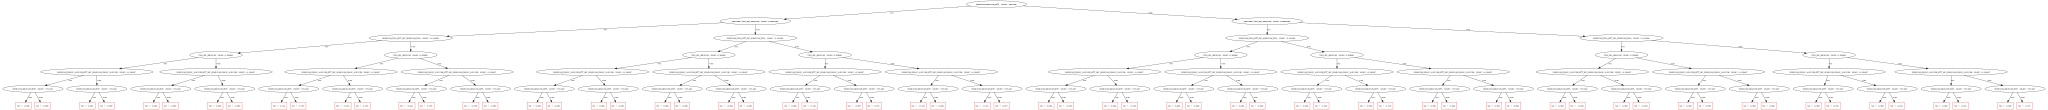

In [143]:
best_model.plot_tree(0,train_pools[np.argmax(validation_scores)])

In [144]:
worst_model = models[np.argmin(validation_scores)]

In [145]:
worst_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,predicted_duration_diff,10.817998
1,fare_per_distance,6.503135
2,predicted_fare_diff_per_fare,6.245750
3,predicted_additional_fare_diff_per_additional_...,6.043267
4,predicted_fare_diff_per_predicted_fare,4.940786
...,...,...
72,duration_meter_waiting_fare_anomaly,0.000000
73,meter_waiting_meter_waiting_fare_anomaly,0.000000
74,additional_fare_duration_meter_waiting_fare_an...,0.000000
75,additional_fare_duration_meter_waiting_meter_w...,0.000000


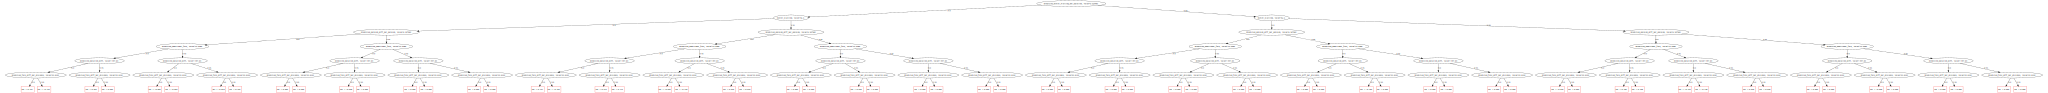

In [146]:
worst_model.plot_tree(0,train_pools[np.argmax(validation_scores)])

In [147]:
cv_params = {
    'loss_function':'Logloss',
    'random_state':0,
    'early_stopping_rounds':50,
    'eval_metric':'F1',
    'verbose': False
}

In [148]:
cv_pool = Pool(data=train_df,label=labels)

In [149]:
scores = cv(cv_pool,cv_params,plot=True, fold_count=3)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [150]:
def filter_features(features):
    features_to_drop = []
    features_to_keep = []
    for feature in features:
        if feature in features_to_drop:
            continue
        highly_corr_features = list((np.array(features))[np.abs(train_df[features].corr()[feature]) > 0.8])
        for each in highly_corr_features:
            if each == feature or each in features_to_keep:
                continue
            else:
                features_to_drop.append(each)
        features_to_keep.append(feature)
    return features_to_keep

In [151]:
f = list(best_model.get_feature_importance(prettified=True)['Feature Id'].values)
new_features = filter_features(f)

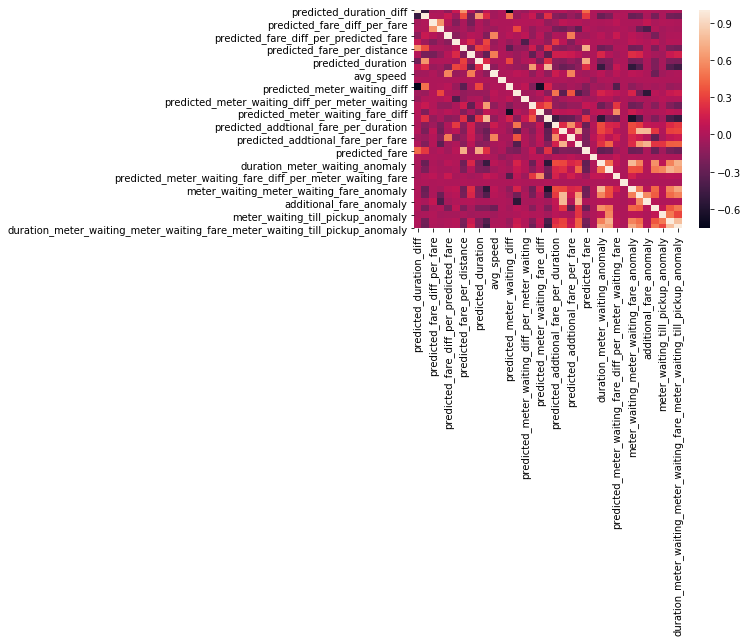

In [152]:
sns.heatmap(train_df[new_features].corr())

In [153]:
train_df = train_df[new_features]

In [154]:
submission_pool = Pool(data=test_df[new_features])

In [155]:
validation_scores = []
submission_preds = np.zeros(submission_df.shape[0])
train_pools = []
models = []
for train_index, test_index in skf.split(train_df, labels):
    X_train, X_test = train_df.iloc[train_index,:], train_df.iloc[test_index,:]
    y_train, y_test = labels[train_index], labels[test_index]
    train_pool = Pool(data=X_train, label=y_train)
    test_pool = Pool(data=X_test, label=y_test)    
    model = CatBoostClassifier(**params)
    model.fit(X=train_pool, eval_set=test_pool,verbose=10)
    pred = model.predict(test_pool)
    validation_score = model.best_score_['validation']['F1']
    print('Validation f1',validation_score)
    validation_scores.append(validation_score)
    models.append(model)
    train_pools.append(train_pool)
    submission_preds += model.predict(submission_pool)

Learning rate set to 0.057693
0:	learn: 0.9713306	test: 0.9755771	best: 0.9755771 (0)	total: 9.04ms	remaining: 9.03s
10:	learn: 0.9731582	test: 0.9757309	best: 0.9759128 (7)	total: 72.8ms	remaining: 6.54s
20:	learn: 0.9751814	test: 0.9776841	best: 0.9776841 (20)	total: 139ms	remaining: 6.48s
30:	learn: 0.9760436	test: 0.9783193	best: 0.9785153 (26)	total: 212ms	remaining: 6.62s
40:	learn: 0.9768199	test: 0.9783882	best: 0.9786825 (39)	total: 275ms	remaining: 6.43s
50:	learn: 0.9773795	test: 0.9786744	best: 0.9787765 (44)	total: 342ms	remaining: 6.36s
60:	learn: 0.9777565	test: 0.9787561	best: 0.9789443 (58)	total: 409ms	remaining: 6.29s
70:	learn: 0.9781764	test: 0.9788339	best: 0.9789443 (58)	total: 478ms	remaining: 6.25s
80:	learn: 0.9786948	test: 0.9791286	best: 0.9792268 (79)	total: 557ms	remaining: 6.31s
90:	learn: 0.9792177	test: 0.9790264	best: 0.9792268 (79)	total: 621ms	remaining: 6.2s
100:	learn: 0.9797349	test: 0.9789160	best: 0.9793130 (93)	total: 691ms	remaining: 6.15s
110

In [156]:
np.mean(validation_scores), np.std(validation_scores)

(0.9764318358549895, 0.0029621287393683)

In [157]:
submission_df['prediction'] = np.where(submission_preds > 2, 1, 0)
submission_df.to_csv('submission_filtered.csv',index=False)

In [158]:
best_model = models[np.argmax(validation_scores)]

In [159]:
best_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,predicted_duration_diff,15.395273
1,fare_per_distance,13.392357
2,predicted_fare_diff_per_fare,10.030476
3,predicted_fare_diff_per_predicted_fare,9.821991
4,predicted_additional_fare_diff_per_additional_...,6.640846
5,predicted_avg_speed,5.954692
6,predicted_fare_per_distance,4.682419
7,predicted_meter_waiting_diff,3.720999
8,predicted_fare_per_duration,3.206761
9,predicted_meter_waiting_fare_diff,2.763659


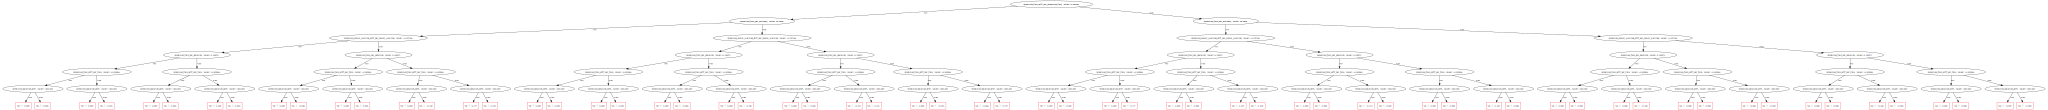

In [160]:
best_model.plot_tree(0,train_pools[np.argmax(validation_scores)])

In [161]:
cv_pool = Pool(data=train_df,label=labels)

In [162]:
scores = cv(cv_pool,cv_params,plot=True, fold_count=3)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))